In [1]:
import pandas as pd 
import lightgbm as lg 
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import RFE, RFECV
import imblearn as imb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, StackingClassifier, ExtraTreesClassifier,VotingClassifier
import sklearn.preprocessing as prep 
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate
from category_encoders import TargetEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
import numpy as np 
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
import matplotlib.pyplot as plt 
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.decomposition import PCA
from imblearn import over_sampling, ensemble, combine, under_sampling
from imblearn import pipeline as imb_pipe
import mlens.ensemble as ens 
from mlens.metrics import make_scorer
from hyperopt import STATUS_OK, hp
from hyperopt.pyll.stochastic import sample
import utils



Using TensorFlow backend.
[MLENS] backend: threading


In [2]:
train = pd.read_parquet(r'.\data\train.parquet').reset_index().drop(['id'], axis = 1)
Y = 'label'
y = train[Y]
train = train.drop([Y], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(train, y, test_size = 0.2,stratify = y, random_state = 42)
X_train.head(10)
print(y.value_counts())


0    487677
1    112323
Name: label, dtype: int64


In [3]:
#new parameter space using hyperopt functions. They are mostly inspired in scipy and numpy distribution functions
hp_param_space = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.3)),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'max_depth': hp.quniform('max_depth', 20, 300, 10),
    'num_leaves': hp.quniform('num_leaves', 10, 200, 20),
    'min_child_samples': hp.quniform('min_child_samples', 1, 20, 5),
    'n_estimators': hp.loguniform('n_estimators', np.log(300), np.log(2000)),
}

def objective_ensemble(params, n_folds = 4):

    global ITERATION 

    ITERATION += 1
    
    #get parameters from the parameter grid
    #p_C = params['C']
    p_learning_rate = params['learning_rate']
    p_max_depth = int(params['max_depth'])
    p_reg_alpha = params['reg_alpha']
    p_reg_lambda = params['reg_lambda']
    p_num_leaves = int(params['num_leaves'])
    p_min_child_samples = int(params['min_child_samples'])
    p_n_estimators = int(params['n_estimators'])

    #creator of folds based on our label (stratified)
    folder = StratifiedKFold(n_splits = n_folds)

    #list to accumulate results
    res = []

    #manually perform the CV process to ensure that encodings are applied in a realistic manner
    for train_index, test_index in folder.split(X = X_train, y = y_train): 
        X_train_k, X_test_k = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_k, y_test_k = y_train.iloc[train_index], y_train.iloc[test_index]

        #remove NAs from the current folds
        X_test_k, one_hot_cols, one_hot_num_cols, numeric_cols, target_cols, emb_cols = utils.remove_nas(X_test_k)
        X_train_k, one_hot_cols, one_hot_num_cols, numeric_cols, target_cols, emb_cols = utils.remove_nas(X_train_k)

        #create the models
        final_pipeline = utils.build_and_fit_pipeline(X_train_k, y_train_k, one_hot_cols, one_hot_num_cols, numeric_cols, target_cols, emb_cols, 
                                                      p_n_estimators = p_n_estimators, p_learning_rate=p_learning_rate, 
                                                      p_max_depth = p_max_depth, p_reg_alpha = p_reg_alpha, 
                                                      p_reg_lambda=p_reg_lambda, p_num_leaves = p_num_leaves, p_min_child_samples = p_min_child_samples)

        #using a pipeline we are processing the test set as well
        probs = final_pipeline.predict_proba(X_test_k)
        preds = final_pipeline.predict(X_test_k)
        # calculate AUC
        probs = probs[:, 1]
        auc = round(roc_auc_score(y_test_k, probs), 3)
        print('AUC: %.3f' % auc)

        print(confusion_matrix(y_test_k, preds))

        res.append(auc)

    #get the results from the iterations    
    best_score = round(np.average(res), 3)

    #minimize loss even when the metric to be evaluated has to be maximized
    loss = round(1 - best_score, 3)

    return {'loss': loss, 'params' : params, 'iteration': ITERATION, 'status' : STATUS_OK}


In [4]:
#hypertune our ensemble model
from hyperopt import tpe, Trials, fmin

n_iters = 2
tpe_algorithm = tpe.suggest
bayesian_trials_ensemble = Trials()

global ITERATION 
ITERATION = 0

#find minimum loss distribution with the same amount of iterations than random search
best_ensemble = fmin(fn = objective_ensemble, space = hp_param_space, 
                    algo = tpe_algorithm, max_evals = n_iters, trials = bayesian_trials_ensemble, 
                    rstate = np.random.RandomState(42))


  0%|          | 0/2 [23:26<?, ?it/s, best loss: ?][[70315 27221]
 [ 7132 15332]]
  0%|          | 0/2 [40:46<?, ?it/s, best loss: ?][[69662 27874]
 [ 6849 15615]]
  0%|          | 0/2 [58:41<?, ?it/s, best loss: ?][[69073 28462]
 [ 6641 15824]]
  0%|          | 0/2 [1:12:50<?, ?it/s, best loss: ?][[69069 28466]
 [ 6747 15718]]
 50%|█████     | 1/2 [1:28:39<1:12:50, 4370.57s/it, best loss: 0.222][[70103 27433]
 [ 7070 15394]]
 50%|█████     | 1/2 [1:44:29<1:12:50, 4370.57s/it, best loss: 0.222][[69554 27982]
 [ 6810 15654]]
 50%|█████     | 1/2 [1:59:53<1:12:50, 4370.57s/it, best loss: 0.222][[69005 28530]
 [ 6616 15849]]
 50%|█████     | 1/2 [2:15:40<1:12:50, 4370.57s/it, best loss: 0.222][[68892 28643]
 [ 6706 15759]]
100%|██████████| 2/2 [2:15:40<00:00, 4070.44s/it, best loss: 0.222]


In [5]:
#get best parameter combination and cast to int the ones that are required 
bayesian_results_ensemble = sorted(bayesian_trials_ensemble.results, key = lambda x: x['loss'])[0]
bayesian_results_ensemble['params']['num_leaves'] = int(bayesian_results_ensemble['params']['num_leaves'])
bayesian_results_ensemble['params']['n_estimators'] = int(bayesian_results_ensemble['params']['n_estimators'])
bayesian_results_ensemble['params']['max_depth'] = int(bayesian_results_ensemble['params']['max_depth'])
bayesian_results_ensemble['params']['min_child_samples'] = int(bayesian_results_ensemble['params']['min_child_samples'])

#clean and complete datasets out of the CV loop
X_test, one_hot_cols, one_hot_num_cols, numeric_cols, target_cols, emb_cols = utils.remove_nas(X_test)
X_train, one_hot_cols, one_hot_num_cols, numeric_cols, target_cols, emb_cols = utils.remove_nas(X_train)

#build and fit our final pipeline with best hyperparameter values
final_pipeline = utils.build_and_fit_pipeline(X_train, y_train
                                                ,one_hot_cols, one_hot_num_cols, numeric_cols, target_cols, emb_cols
                                                ,p_n_estimators=bayesian_results_ensemble['params']['n_estimators']
                                                ,p_learning_rate=bayesian_results_ensemble['params']['learning_rate']
                                                ,p_max_depth=bayesian_results_ensemble['params']['max_depth']
                                                ,p_reg_alpha=bayesian_results_ensemble['params']['reg_alpha']
                                                ,p_reg_lambda=bayesian_results_ensemble['params']['reg_lambda']
                                                ,p_num_leaves=bayesian_results_ensemble['params']['num_leaves']
                                                ,p_min_child_samples=bayesian_results_ensemble['params']['min_child_samples']
)



In [6]:
from joblib import dump, load 
import pickle 

dump(final_pipeline, r'.\models\final_pipeline.pkl')


['.\\models\\final_pipeline.pkl']

In [7]:
#get our final step of the pipeline
final_model = final_pipeline.named_steps['classifier']
final_model.final_estimator_


LogisticRegression(C=0.2, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=6000, multi_class='auto', n_jobs=4, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [69]:
#get real feature names from the preprocessors
cat_names = list(final_pipeline['preprocess'].transformers_[0][1][0].get_feature_names(one_hot_cols))
cat_num_names = list(final_pipeline['preprocess'].transformers_[1][1][0].get_feature_names(one_hot_num_cols))


In [70]:
#since it is a logistic regression model we'll relay on the coefficients, in scale
feature_importance = abs(final_model.final_estimator_.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

#original names
train_columns = list(X_train.columns)

#drop one-hot-encoded original names
train_columns = list(set(train_columns) - set(one_hot_cols))
train_columns = list(set(train_columns) - set(one_hot_num_cols))

#scores from the estimators
estimator_feats = ['lr_est', 'lgb_1_est', 'ada_est', 'lgb2_est', 'lgb3_est']

cat_names.extend(cat_num_names)
cat_names.extend(train_columns)
cat_names.extend(estimator_feats)
cat_names


['bin_4_N',
 'bin_4_Y',
 'bin_3_F',
 'bin_3_T',
 'bin_0_0.0',
 'bin_0_1.0',
 'bin_1_0.0',
 'bin_1_1.0',
 'bin_2_0.0',
 'bin_2_1.0',
 'ord_2',
 'nom_4',
 'ord_1',
 'nom_9',
 'ord_4',
 'nom_3',
 'day',
 'month',
 'nom_1',
 'ord_5',
 'nom_2',
 'nom_8',
 'ord_3',
 'nom_7',
 'nom_5',
 'nom_6',
 'ord_0',
 'nom_0',
 'lr_est',
 'lgb_1_est',
 'ada_est',
 'lgb2_est',
 'lgb3_est']

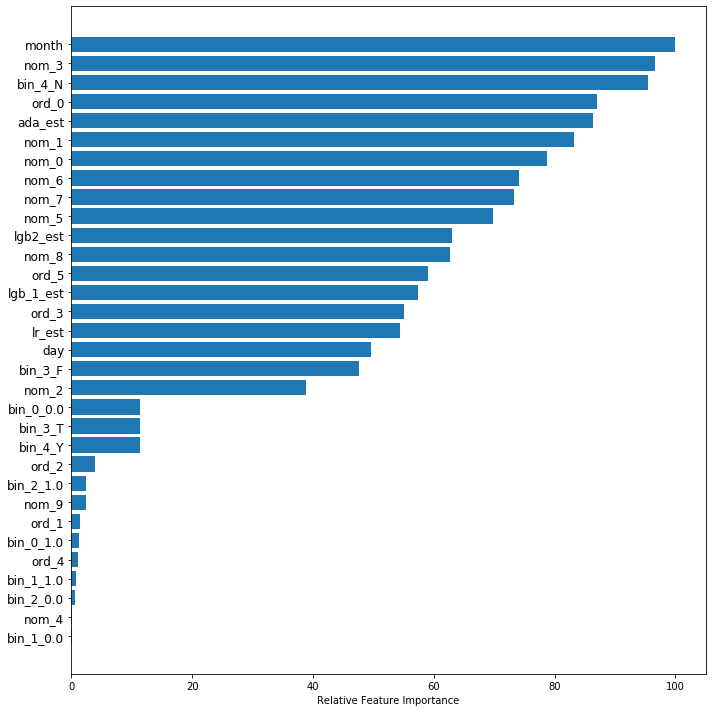

In [71]:
#plot
featfig = plt.figure(figsize=(10, 10))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(cat_names)[sorted_idx], fontsize=12)
featax.set_xlabel('Relative Feature Importance')

plt.tight_layout()   
plt.show()
